In [942]:
from functools import partial
from math import ceil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from web3 import Web3, HTTPProvider
import requests
from tqdm import tqdm

In [928]:
from requests.adapters import HTTPAdapter

s = requests.Session()
s.mount('https://api.arbiscan.io', HTTPAdapter(max_retries=5))

In [8]:
ARBISCAN_API_KEY='CHANGEME'

In [929]:
def get_address_transactions(address, start_block, end_block):
    """Gets all transactions in block_id from Etherscan"""
    # TODO: Make this desc?
    url = f"https://api.arbiscan.io/api?module=account&action=txlist&address={address}" \
          f"&startblock={start_block}&endblock={end_block}&sort=asc&apikey={ARBISCAN_API_KEY}"
    resp = s.get(url)

    if resp.status_code != 200:
        raise Exception("Bad response from arbiscan txlist")

    return resp.json()['result']

In [1181]:
gmx_stake_addr='0xa906f338cb21815cbc4bc87ace9e68c87ef8d8f1'
uniswapv3_addr='0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45'
start, end = 20000000, 26563451

uni_results = []
gmx_results = []

total_calls = ceil((end-start)/2000)
print(f"Making {total_calls} Arbiscan calls")

for i in tqdm(range(start, end, 2000)):
    gmx_result = get_address_transactions(gmx_stake_addr, i, i+2000)
    uni_result = get_address_transactions(uniswapv3_addr, i, i+2000)
    
    if not gmx_result or not uni_result:
        raise Exception("Null response")
    
    gmx_results.extend(gmx_result)
    uni_results.extend(uni_result)
    
uni_result = uni_results
gmx_result = gmx_results

Making 10032 Arbiscan calls


  9%|█████▎                                                   | 927/10032 [08:32<1:23:53,  1.81it/s]


Exception: Null response

In [1178]:
# TODO: Pickle the results?
a1 = gmx_results
a2 = uni_results

In [931]:
print(len(gmx_results))
print(len(uni_results))

119919
692498


In [932]:
# Filter for unstakes only
unstake_txs = list(filter(lambda j: j['functionName'] == 'unstakeGmx(uint256 _amount)', gmx_result))

# Filter for multicall only
multicall_txs = list(filter(lambda j: j['functionName'] == 'multicall(uint256 deadline, bytes[] data)', uni_result))

In [933]:
# Filter for success only
unstake_txs = list(filter(lambda j: j['isError'] != '1', unstake_txs))
multicall_txs = list(filter(lambda j: j['isError'] != '1', multicall_txs))

In [934]:
node_url = 'https://arb-mainnet.g.alchemy.com/v2/CHANGEME'
web3 = Web3(HTTPProvider(node_url))

In [935]:
class GmxContract:
    abi = """[{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"StakeGlp","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"},{"indexed":false,"internalType":"address","name":"token","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"StakeGmx","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"UnstakeGlp","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"},{"indexed":false,"internalType":"address","name":"token","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"UnstakeGmx","type":"event"},{"inputs":[{"internalType":"address","name":"_sender","type":"address"}],"name":"acceptTransfer","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address[]","name":"_accounts","type":"address[]"}],"name":"batchCompoundForAccounts","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address[]","name":"_accounts","type":"address[]"},{"internalType":"uint256[]","name":"_amounts","type":"uint256[]"}],"name":"batchStakeGmxForAccount","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"bnGmx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"bonusGmxTracker","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"claim","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"claimEsGmx","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"claimFees","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"compound","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_account","type":"address"}],"name":"compoundForAccount","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"esGmx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGlpTracker","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGmxTracker","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"glp","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"glpManager","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"glpVester","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"gmx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"gmxVester","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"gov","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bool","name":"_shouldClaimGmx","type":"bool"},{"internalType":"bool","name":"_shouldStakeGmx","type":"bool"},{"internalType":"bool","name":"_shouldClaimEsGmx","type":"bool"},{"internalType":"bool","name":"_shouldStakeEsGmx","type":"bool"},{"internalType":"bool","name":"_shouldStakeMultiplierPoints","type":"bool"},{"internalType":"bool","name":"_shouldClaimWeth","type":"bool"},{"internalType":"bool","name":"_shouldConvertWethToEth","type":"bool"}],"name":"handleRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_weth","type":"address"},{"internalType":"address","name":"_gmx","type":"address"},{"internalType":"address","name":"_esGmx","type":"address"},{"internalType":"address","name":"_bnGmx","type":"address"},{"internalType":"address","name":"_glp","type":"address"},{"internalType":"address","name":"_stakedGmxTracker","type":"address"},{"internalType":"address","name":"_bonusGmxTracker","type":"address"},{"internalType":"address","name":"_feeGmxTracker","type":"address"},{"internalType":"address","name":"_feeGlpTracker","type":"address"},{"internalType":"address","name":"_stakedGlpTracker","type":"address"},{"internalType":"address","name":"_glpManager","type":"address"},{"internalType":"address","name":"_gmxVester","type":"address"},{"internalType":"address","name":"_glpVester","type":"address"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"isInitialized","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_token","type":"address"},{"internalType":"uint256","name":"_amount","type":"uint256"},{"internalType":"uint256","name":"_minUsdg","type":"uint256"},{"internalType":"uint256","name":"_minGlp","type":"uint256"}],"name":"mintAndStakeGlp","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_minUsdg","type":"uint256"},{"internalType":"uint256","name":"_minGlp","type":"uint256"}],"name":"mintAndStakeGlpETH","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"pendingReceivers","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_gov","type":"address"}],"name":"setGov","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_receiver","type":"address"}],"name":"signalTransfer","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"stakeEsGmx","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"stakeGmx","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_account","type":"address"},{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"stakeGmxForAccount","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"stakedGlpTracker","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakedGmxTracker","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_tokenOut","type":"address"},{"internalType":"uint256","name":"_glpAmount","type":"uint256"},{"internalType":"uint256","name":"_minOut","type":"uint256"},{"internalType":"address","name":"_receiver","type":"address"}],"name":"unstakeAndRedeemGlp","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_glpAmount","type":"uint256"},{"internalType":"uint256","name":"_minOut","type":"uint256"},{"internalType":"address payable","name":"_receiver","type":"address"}],"name":"unstakeAndRedeemGlpETH","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"unstakeEsGmx","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"unstakeGmx","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"weth","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_token","type":"address"},{"internalType":"address","name":"_account","type":"address"},{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"withdrawToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"stateMutability":"payable","type":"receive"}]"""
    contract = web3.eth.contract(address=Web3.toChecksumAddress(gmx_stake_addr), abi=abi)

In [936]:
class UniswapContract:
    abi = """[{"inputs":[{"internalType":"address","name":"_factoryV2","type":"address"},{"internalType":"address","name":"factoryV3","type":"address"},{"internalType":"address","name":"_positionManager","type":"address"},{"internalType":"address","name":"_WETH9","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"WETH9","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"approveMax","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"approveMaxMinusOne","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"approveZeroThenMax","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"approveZeroThenMaxMinusOne","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"bytes","name":"data","type":"bytes"}],"name":"callPositionManager","outputs":[{"internalType":"bytes","name":"result","type":"bytes"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"paths","type":"bytes[]"},{"internalType":"uint128[]","name":"amounts","type":"uint128[]"},{"internalType":"uint24","name":"maximumTickDivergence","type":"uint24"},{"internalType":"uint32","name":"secondsAgo","type":"uint32"}],"name":"checkOracleSlippage","outputs":[],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes","name":"path","type":"bytes"},{"internalType":"uint24","name":"maximumTickDivergence","type":"uint24"},{"internalType":"uint32","name":"secondsAgo","type":"uint32"}],"name":"checkOracleSlippage","outputs":[],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"bytes","name":"path","type":"bytes"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMinimum","type":"uint256"}],"internalType":"struct IV3SwapRouter.ExactInputParams","name":"params","type":"tuple"}],"name":"exactInput","outputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"tokenIn","type":"address"},{"internalType":"address","name":"tokenOut","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMinimum","type":"uint256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"}],"internalType":"struct IV3SwapRouter.ExactInputSingleParams","name":"params","type":"tuple"}],"name":"exactInputSingle","outputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"bytes","name":"path","type":"bytes"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"amountInMaximum","type":"uint256"}],"internalType":"struct IV3SwapRouter.ExactOutputParams","name":"params","type":"tuple"}],"name":"exactOutput","outputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"tokenIn","type":"address"},{"internalType":"address","name":"tokenOut","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"amountInMaximum","type":"uint256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"}],"internalType":"struct IV3SwapRouter.ExactOutputSingleParams","name":"params","type":"tuple"}],"name":"exactOutputSingle","outputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"factoryV2","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"getApprovalType","outputs":[{"internalType":"enum IApproveAndCall.ApprovalType","name":"","type":"uint8"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"uint256","name":"amount0Min","type":"uint256"},{"internalType":"uint256","name":"amount1Min","type":"uint256"}],"internalType":"struct IApproveAndCall.IncreaseLiquidityParams","name":"params","type":"tuple"}],"name":"increaseLiquidity","outputs":[{"internalType":"bytes","name":"result","type":"bytes"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint256","name":"amount0Min","type":"uint256"},{"internalType":"uint256","name":"amount1Min","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"internalType":"struct IApproveAndCall.MintParams","name":"params","type":"tuple"}],"name":"mint","outputs":[{"internalType":"bytes","name":"result","type":"bytes"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"previousBlockhash","type":"bytes32"},{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"","type":"bytes[]"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"","type":"bytes[]"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"bytes[]","name":"data","type":"bytes[]"}],"name":"multicall","outputs":[{"internalType":"bytes[]","name":"results","type":"bytes[]"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"positionManager","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"pull","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"refundETH","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"nonce","type":"uint256"},{"internalType":"uint256","name":"expiry","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitAllowed","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"nonce","type":"uint256"},{"internalType":"uint256","name":"expiry","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitAllowedIfNecessary","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"selfPermitIfNecessary","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"}],"name":"swapExactTokensForTokens","outputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"amountInMax","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"}],"name":"swapTokensForExactTokens","outputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"name":"sweepToken","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountMinimum","type":"uint256"}],"name":"sweepToken","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"uint256","name":"feeBips","type":"uint256"},{"internalType":"address","name":"feeRecipient","type":"address"}],"name":"sweepTokenWithFee","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"feeBips","type":"uint256"},{"internalType":"address","name":"feeRecipient","type":"address"}],"name":"sweepTokenWithFee","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"int256","name":"amount0Delta","type":"int256"},{"internalType":"int256","name":"amount1Delta","type":"int256"},{"internalType":"bytes","name":"_data","type":"bytes"}],"name":"uniswapV3SwapCallback","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"name":"unwrapWETH9","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountMinimum","type":"uint256"}],"name":"unwrapWETH9","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"feeBips","type":"uint256"},{"internalType":"address","name":"feeRecipient","type":"address"}],"name":"unwrapWETH9WithFee","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountMinimum","type":"uint256"},{"internalType":"uint256","name":"feeBips","type":"uint256"},{"internalType":"address","name":"feeRecipient","type":"address"}],"name":"unwrapWETH9WithFee","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"value","type":"uint256"}],"name":"wrapETH","outputs":[],"stateMutability":"payable","type":"function"},{"stateMutability":"payable","type":"receive"}]"""
    contract = web3.eth.contract(address=Web3.toChecksumAddress(uniswapv3_addr), abi=abi)

In [937]:
def get_price(coin):
    resp = requests.get(f'https://api.coingecko.com/api/v3/simple/price?ids={coin}&vs_currencies=usd')
    return resp.json()[coin]['usd']

coin_prices = {'usdc': 1}
coins = ['gmx']
for coin in coins:
    # We work with a constant price
    price = get_price(coin)
    coin_prices[coin] = price

In [938]:
class GmxUniswapSellTx:
    def __init__(self, gmx_amount, timestamp, address, tx_hash):
        self.gmx_amount = gmx_amount
        self.gmx_usd_amount = coin_prices['gmx'] * gmx_amount
        #self.eth_amount = eth_amount
        self.timestamp = timestamp
        self.address = address
        self.tx_hash = tx_hash
        
class GmxUnstakeTx:
    def __init__(self, gmx_amount, burned_apy, timestamp, address, tx_hash):
        self.gmx_amount = gmx_amount
        self.gmx_usd_amount = coin_prices['gmx'] * gmx_amount
        self.burned_apy = burned_apy
        self.timestamp = timestamp
        self.address = address
        self.tx_hash = tx_hash

In [939]:
TRANSFER_HASH = Web3.keccak(text='Transfer(address,address,uint256)')
def try_decode_transfer_log(log):
    topics = log['topics']
    if topics[0] != TRANSFER_HASH:
        return None, None, None

    fro = "0x" + topics[1].hex().lstrip("0x").lstrip("0")
    to = "0x" + topics[2].hex().lstrip("0x").lstrip("0")

    amount = int(log['data'], 16) / 1e18
    return amount, to, fro


def bonus_burn_from_tx(tx):
    """Get the total amount of tokens that have been unstaked in tx"""
    tx_receipt = web3.eth.get_transaction_receipt(tx['hash'])
    logs = tx_receipt['logs']

    try:
        burn_log = logs[-2]
    except:
        print(tx['hash'])
        raise

    amount, _, _ = try_decode_transfer_log(burn_log)
    return amount

In [943]:
unstake_objs = []
for tx in tqdm(unstake_txs):
    args = GmxContract.contract.decode_function_input(tx['input'])
    gmx_amount = args[1]['_amount'] / 1e18
    ts = int(tx['timeStamp'])
    
    # Get burned apy
    burned_bonus = bonus_burn_from_tx(tx)
    burned_apy = round(burned_bonus / gmx_amount * 100, 0)
    
    # Create unstake obj
    unstake_tx = GmxUnstakeTx(gmx_amount, burned_apy, ts, tx['from'], tx['hash'])
    unstake_objs.append(unstake_tx)

100%|███████████████████████████████████████████████████████████| 6893/6893 [28:43<00:00,  4.00it/s]


In [944]:
len(unstake_objs)

6893

In [945]:
name_abi = """[{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"}]"""
coin_dict = {'0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8'.lower(): 'usdc', '0xfc5a1a6eb076a2c7ad06ed22c90d7e710e35ad0a': 'gmx'}
def get_coin_name(address):
    return coin_dict.get(address)

In [946]:
def get_uniswap_execution(tx, recipient):
    """Get the total amount of tokens that have been sold in tx"""
    recipient = recipient.lower()
    transfers_in, transfers_out = {}, {}
    tx_receipt = web3.eth.get_transaction_receipt(tx['hash'])
    logs = tx_receipt['logs']

    for log in logs:
        amount, to, fro = try_decode_transfer_log(log)
        if recipient == fro:
            # Only get registered coins
            coin_name = get_coin_name(log['address'].lower())
            if not coin_name:
                continue
                
            if coin_name not in transfers_out:
                transfers_out[coin_name] = amount
            else:
                transfers_out[coin_name] += amount
                
            if coin_name in transfers_in:
                print(tx['hash'])
                raise Exception("Double transfer")
            
        if recipient == to:
            # Only get registered coins
            coin_name = get_coin_name(log['address'].lower())
            if not coin_name:
                continue
                
            if coin_name not in transfers_in:
                transfers_in[coin_name] = amount
            else:
                transfers_in[coin_name] += amount
            
            if coin_name in transfers_out:
                print(tx['hash'])
                raise Exception("Double transfer")

    return transfers_in, transfers_out

In [947]:
tx = web3.eth.getTransaction(0xd21a8e3de78ae5724a4a6e589471b44e80d2701a400783b18297df7623c2711e)
args = UniswapContract.contract.decode_function_input(tx['input'])
data = args[1]['data']
gmx_addr = 0xfc5a1a6eb076a2c7ad06ed22c90d7e710e35ad0a
call_args = UniswapContract.contract.decode_function_input(data[0])
func_name = str(call_args[0])

In [948]:
print(call_args)

(<Function exactOutput(tuple)>, {'params': (b"\xb5\xde?\x06\xafb\xd8B\x8a\x8b\xf7\xb4@\x0e\xa4*\xd2\xe0\xbcS\x00'\x10\xff\x97\na\xa0K\x1c\xa1H4\xa4?]\xe4S>\xbd\xdb\\\xc8\x00\x01\xf4\x82\xafID}\x8a\x07\xe3\xbd\x95\xbd\rV\xf3RAR?\xba\xb1", '0x56b72C740C276e2fC0ff5472aA23cA166D0e14B6', 11000000000000000, 750507293554)})


In [949]:
params = call_args[1]['params']
path, recipient, amountIn, amountOutMinimum = params
len(path.hex())

132

In [950]:
path.hex() # gmx, weth, usdc

'b5de3f06af62d8428a8bf7b4400ea42ad2e0bc53002710ff970a61a04b1ca14834a43f5de4533ebddb5cc80001f482af49447d8a07e3bd95bd0d56f35241523fbab1'

In [951]:
# Filter for transactions that don't sell GMX, this still contains few false positives
# This filter is to limit calling alchemy

filtered_multicall_txs = []
gmx_addr = "0xfc5a1a6eb076a2c7ad06ed22c90d7e710e35ad0a"
for tx in tqdm(multicall_txs):
    args = UniswapContract.contract.decode_function_input(tx['input'])
    tx['args'] = args
    data = args[1]['data']
    
    good = False
    for call in data:
        try:
            call_args = UniswapContract.contract.decode_function_input(call)
        except:
            print(tx['hash'])
        func_name = str(call_args[0])
        
        if func_name == '<Function exactInputSingle(tuple)>':
            params = call_args[1]['params']
            tokenIn, tokenOut, fee, recipient, amountIn, amountOutMinimum, sqrtPriceLimitX96 = params

            # Filter for GMX txs
            if tokenIn.lower() == gmx_addr:
                good = True
                break 
            
        elif func_name == '<Function exactInput(tuple)>':
            params = call_args[1]['params']
            path, recipient, amountIn, amountOutMinimum = params
            
            if path.hex()[:40] == gmx_addr[2:]:
                good = True
                break
            
        elif func_name == '<Function exactOutput(tuple)>':
            #params = call_args[1]['params']
            #path, recipient, amountOut, amountInMaximum = params
            # This is a buy, continue
            continue
        
        elif func_name == '<Function exactOutputSingle(tuple)>':
            #params = call_args[1]['params']
            #tokenIn, tokenOut, fee, recipient, amountOut, amountInMaximum, sqrtPriceLimitX96 = params
            # This is a buy, continue
            continue
    
    if good:
        filtered_multicall_txs.append(tx)

100%|██████████████████████████████████████████████████████| 577178/577178 [17:37<00:00, 545.59it/s]


In [952]:
print(len(filtered_multicall_txs))

11305


In [953]:
sell_objs = []
for tx in tqdm(filtered_multicall_txs):
    args = tx['args']
    data = args[1]['data']
    transfers_in, transfers_out = get_uniswap_execution(tx, tx['from'])
    
    # Filter for GMX sells only
    if 'gmx' not in transfers_out:
        continue
    # transfers['usdc'] *= 1e18/1e6
    
    sell_obj = GmxUniswapSellTx(transfers_out['gmx'], int(tx['timeStamp']), tx['from'], tx['hash'])
    sell_objs.append(sell_obj)

In [954]:
len(sell_objs)

10691

In [1095]:
df1 = pd.DataFrame.from_records([['sell', o.timestamp, o.gmx_amount, o.address, o.tx_hash] for o in sell_objs])
df2 = pd.DataFrame.from_records([['unstake', o.timestamp, o.gmx_amount, o.address, o.tx_hash, o.burned_apy] for o in unstake_objs])
df = pd.concat([df1, df2])
df.rename({0: 'event', 1: 'timestamp', 2: 'gmx_amount', 3: 'address', 4: 'hash', 5: 'burned_apy'}, axis=1, inplace=True)
df.sort_values(['timestamp'], inplace=True)
df.reset_index(inplace=True)
del df['index']

# Sells should be negative
df.loc[df['event'] == 'sell', 'gmx_amount'] *= -1

df.head()

,event,timestamp,gmx_amount,address,hash,burned_apy
0,sell,1660217794,-200.0,0xd0cffe2244ef4c4c6e0ac4c11cd54f8a30b991b5,0x3a76e65a52888c9a451781d6a2ca05aaf490c3458084...,NaN
1,unstake,1660217942,50.0,0x33b44ed09fe9002c101db139dbeee488a825875a,0x20d0b831a71ce4cc4f9e8dfec386826191462029e217...,19.0
2,sell,1660217953,-50.0,0x33b44ed09fe9002c101db139dbeee488a825875a,0xc7c91d63adc6327e3269c58d63b3e44614ea66b63e4a...,NaN
3,unstake,1660218027,12.0,0xa950555cb3249f9baf0c2149459174592c79efac,0x398d489e08b7b8efa78b4025b58a63c8ec66cb20900a...,30.0
4,sell,1660218798,-110.0,0xae437ecbd0c698f38e540ae7aba90068271c76c6,0x91bcc17477079d0e8d238da4c7ec381d6be270663680...,NaN


In [1096]:
# Remove addresses who didn't unstake more than 1000 gmx
dftmp = (df.loc[(df['event'] == 'unstake')].groupby('address')['gmx_amount'].sum() > 2500).to_frame()
bad_addr = list(dftmp.loc[dftmp['gmx_amount'] == False].index)
df = df[~df.address.isin(bad_addr)].reset_index()
len(df)

6134

In [1097]:
# Get all addresses that sold everything within 5 minutes of unstaking
mins = 5

def add_ts_filter(x):
    x['ts_filter'] = False
    for i in range(1, 5):
        x.loc[(x['event'] == 'unstake') & (x.shift(-i)['event'] == 'sell'), 'ts_filter'] |= abs(x['timestamp'].diff(-i)) < mins*60
        x.loc[(x['event'] == 'unstake') & (x.shift(-i)['event'] == 'sell') & (abs(x['timestamp'].diff(-i)) < mins*60), 'ts_filter_index'] = -i
    return x

def add_gmx_diff(x):
    x.loc[x['ts_filter'] == True, 'gmx_diff'] = x['gmx_amount']
    for i in range(1, 5):
        # ex: if -2 we'll cover -1 and -2 indexes
        x.loc[x['ts_filter_index'] <= -i, 'gmx_diff'] += x.shift(-i)['gmx_amount']
    return x

df2 = df.groupby('address').apply(add_ts_filter)
df3 = df2.groupby('address').apply(add_gmx_diff)
df3['diff_rel'] = 1 - df3['gmx_diff'] / df3['gmx_amount']

display(df3[df['address']=="0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167"].head())

,index,event,timestamp,gmx_amount,address,hash,burned_apy,ts_filter,ts_filter_index,gmx_diff,diff_rel
5186,14784,unstake,1663512755,1000.000000,0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167,0xc46e8b17e81d3ff6e039fd44a34443949c1bd76bbe73...,22.0,True,-1.0,0.000000,1.000000
5187,14788,sell,1663512847,-1000.000000,0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167,0xfb78c4565bf3e26ae4ad9a704b7fc755b0f860957d77...,NaN,False,NaN,NaN,NaN
5221,14931,unstake,1663517694,500.000000,0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167,0x05c105548a9d83788227e007d0ffc6a235ec6bd76871...,22.0,True,-1.0,-0.001498,1.000003
5222,14935,sell,1663517734,-500.001498,0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167,0xefa70d7aa29d768f5cc0efb3df531dd5d0ab2c544cce...,NaN,False,NaN,NaN,NaN
5588,16090,unstake,1663712239,500.000000,0x1f77dfeb0e6fed1ecf0b41d4c81330df6a6fb167,0xcd5b2fe2bbdb8e755b1d70f84ed7759549842d037d0b...,14.0,True,-1.0,0.000000,1.000000


In [1108]:
# Amount of users who sold exactly their stake right after unstaking
diff_threshold = 0.9
burned_theshold = 10

stake_sell = len(df3.loc[(df3['diff_rel'] >= diff_threshold) & (df3['gmx_amount'] > 1000)])
print(f"Amount of users who sold exactly their stake right after unstaking: {stake_sell}")

# Amount of users who unstaked without selling
non_sell_df = df3.loc[(df3['gmx_amount'] > 1000) & (((df3['ts_filter'] == False) & (df3['event'] == 'unstake')) | (df3['diff_rel'] < diff_threshold) & (df3['diff_rel'] > 0))]
non_sell = len(non_sell_df)
print(f"Amount of users who unstaked without selling: {non_sell}")

Amount of users who sold exactly their stake right after unstaking: 156
Amount of users who unstaked without selling: 169


In [1109]:
non_sell_df

,index,event,timestamp,gmx_amount,address,hash,burned_apy,ts_filter,ts_filter_index,gmx_diff,diff_rel
33,108,unstake,1660241716,1500.000000,0x75691b20d872be09243a6cc24fe815d10f089847,0x787acc11d9c3d5f38bf3890c2caa2f8f37fe48f9b28a...,4.0,False,NaN,NaN,NaN
38,123,unstake,1660244179,2000.000000,0x498de87f620f9db59604dcc2edc5ab7e7639baa2,0x6e51a5ef1e73990e95a8cf85bd091108b2b7eb25a1c8...,5.0,False,NaN,NaN,NaN
57,152,unstake,1660247868,4999.107139,0x7b4a0ac7741c7e6cfc8b96d4760e219dbf13da82,0x496cebc03c06b42634ef5a305523a1cef3a2cf5e7efe...,1.0,False,NaN,NaN,NaN
89,201,unstake,1660258729,4641.536572,0x2a9c628f9b1b06a881407ae457ffb0e51fb7e752,0x1a3915c87bc57e8f5bd8dbbf03b3fef1bffc4337b194...,1.0,False,NaN,NaN,NaN
91,204,unstake,1660258757,9347.161903,0xbd5c4028f58fbe504244ffce386f73577232f1da,0xb28c0ff9d3f2a4c36ed787d4c8594f6cc985be85e3a2...,0.0,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5726,16463,unstake,1663793588,2000.000000,0x942f2d75e01fa5eaf9e127b22326c12311ac5bc1,0xcb32ddb5142eb14d8103ff4b92a0560f1d178fa0ab6e...,32.0,False,NaN,NaN,NaN
5867,16917,unstake,1663891738,5124.148702,0xa88056beee1d5c3b0990003e0a6d699c6e351451,0x975626bf62c89c6b02719b424b5a7e7151d805337350...,44.0,False,NaN,NaN,NaN
5913,17014,unstake,1663922734,12800.000000,0xfbea0772cef0dbe743a18b132bfbb8f9eb0bf0aa,0xc5c5aaea8a299a70dc86aede29112b7445771103f36a...,0.0,False,NaN,NaN,NaN
6024,17307,unstake,1663982971,2648.518552,0x3cda30bd84db976bfabb64b622d74d38e78edfd3,0xf21580cd2c6059c4fe902eaf55df29eeccdfacd30582...,14.0,False,NaN,NaN,NaN


In [1177]:
df3[df['address']=="0xbbcbe6678d49095e09f8e1ea1a346de8c53e7d17"]

,index,event,timestamp,gmx_amount,address,hash,burned_apy,ts_filter,ts_filter_index,gmx_diff,diff_rel
237,625,unstake,1660380607,3500.0,0xbbcbe6678d49095e09f8e1ea1a346de8c53e7d17,0x5242017542d06724b4f3a72695c0035e674db020cf36...,84.0,False,NaN,NaN,NaN
4856,13776,unstake,1663223415,10000.0,0xbbcbe6678d49095e09f8e1ea1a346de8c53e7d17,0xbc5db945c828cfe6f85cba7ebc22facd11ad1c4cab98...,92.0,True,-1.0,0.0,1.0
4857,13777,sell,1663223486,-10000.0,0xbbcbe6678d49095e09f8e1ea1a346de8c53e7d17,0x0aef6834754cf76bbdc9d440e167c0d2c759d79c3275...,NaN,False,NaN,NaN,NaN


In [1111]:
# Amount of users who sold exactly their stake right after unstaking with burned_apy > 10%
stake_sell = len(df3.loc[(df3['diff_rel'] >= diff_threshold) & (df3['burned_apy'] > burned_theshold)])
print(f"Amount of users who sold exactly their stake right after unstaking: {stake_sell}")

# Amount of users who unstaked without selling with burned_apy > 10%
non_sell_df = df3.loc[((df3['ts_filter'] == False) & (df3['event'] == 'unstake') & (df3['burned_apy'] > burned_theshold)) | (df3['diff_rel'] < diff_threshold) & (df3['diff_rel'] > 0)]
non_sell = len(non_sell_df)
print(f"Amount of users who unstaked without selling: {non_sell}")

Amount of users who sold exactly their stake right after unstaking: 138
Amount of users who unstaked without selling: 147


In [1166]:
xs = np.arange(0, 101, 1)
ys = []
for x in xs:
    # unstakers, burned more than x APY, unstaked more than threshold, sold more than threshold
    stake_filter = (df3['event'] == 'unstake') & \
    (df3['burned_apy'] >= x) & \
    (df3['gmx_amount'] > 5000) & \
    (df3['diff_rel'] >= diff_threshold)
    stake_sell = len(df3.loc[stake_filter])
    
    # unstakers, burned more than x APY, unstaked less than threshold, sold less than threshold or later than alloted time
    non_sell_filter = (df3['event'] == 'unstake') & \
    (df3['burned_apy'] >= x) & \
    (df3['gmx_amount'] > 5000) & \
    (((df3['diff_rel'] < diff_threshold) & (df3['diff_rel'] > 0)) | (df3['ts_filter'] == False))
    non_sell = len(df3.loc[non_sell_filter])
    
    if stake_sell+non_sell == 0:
        percent = ys[-1]
    else:
        percent = stake_sell/(stake_sell+non_sell)
        
    ys.append(percent)
    
ys = np.array(ys)*100

Text(0, 0.5, 'Percentage of GMX sellers (%)')

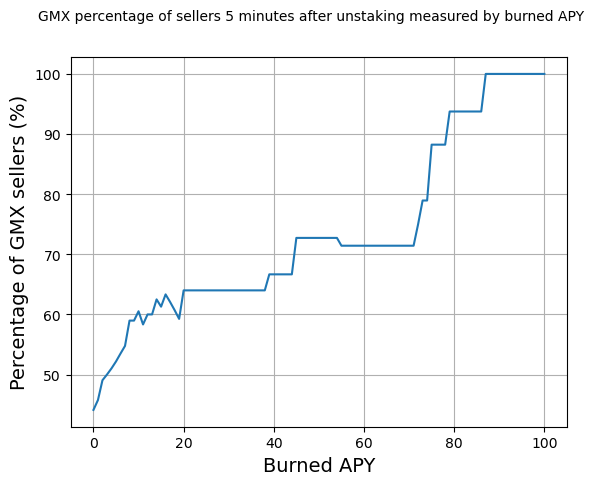

In [1176]:
plt.plot(xs, ys)
plt.grid(True)
plt.suptitle(f'GMX percentage of sellers {mins} minutes after unstaking measured by burned APY', fontsize=10)
plt.xlabel('Burned APY', fontsize=14)
plt.ylabel('Percentage of GMX sellers (%)', fontsize=14)

In [1174]:
x1=90
x2=150
stake_filter = (df3['event'] == 'unstake') & \
    (df3['burned_apy'] >= x1) & (df3['burned_apy'] <= x2) & \
    (df3['gmx_amount'] >= 5000) & \
    (((df3['diff_rel'] > diff_threshold)))
df3.loc[stake_filter]

,index,event,timestamp,gmx_amount,address,hash,burned_apy,ts_filter,ts_filter_index,gmx_diff,diff_rel
2786,7589,unstake,1662036881,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x639732f7fc3f03695a6f89e98315c3f5aaeb3bcbf6e4...,90.0,True,-1.0,0.000000e+00,1.0
2800,7633,unstake,1662042461,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x5cfb2451c306b71a80d9818dc0dd2a3bf316db5fe747...,90.0,True,-1.0,0.000000e+00,1.0
3862,11203,unstake,1662582128,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x2511e1986b3fd7202f5c316ea89a392ed3df6db6c57f...,91.0,True,-2.0,0.000000e+00,1.0
3863,11204,unstake,1662582154,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x92b8cb67a1bfe8206454bdc4cc25af5894d4e9a181b1...,91.0,True,-1.0,-6.000000e+03,2.0
4061,11761,unstake,1662725753,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0xbcfdc18e1fd5fc9c94710602713b7a106ff031a722b0...,92.0,True,-1.0,0.000000e+00,1.0
4188,12065,unstake,1662769852,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x33462db7d30d4ed880f0b0378bd0d48ff93e33076b65...,92.0,True,-1.0,0.000000e+00,1.0
4856,13776,unstake,1663223415,10000.0,0xbbcbe6678d49095e09f8e1ea1a346de8c53e7d17,0xbc5db945c828cfe6f85cba7ebc22facd11ad1c4cab98...,92.0,True,-1.0,0.000000e+00,1.0
4996,14195,unstake,1663359668,6000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0xdb32f549a82a36bad29f2def2ba7f87d564acbef8213...,94.0,True,-1.0,0.000000e+00,1.0
5537,15935,unstake,1663681931,7000.0,0xd33c0ac049b1b7194fcebd1fe5341e6f3ea9d72b,0x2ce0c6d2889f72707f57f50f51f8c43452fe199373d1...,94.0,True,-1.0,9.094947e-13,1.0


In [1175]:
x1=90
x2=150
non_sell_filter = (df3['event'] == 'unstake') & \
    (df3['burned_apy'] >= x1) & (df3['burned_apy'] <= x2) & \
    (df3['gmx_amount'] >= 5000) & \
    (((df3['diff_rel'] < diff_threshold) & (df3['diff_rel'] > 0)) | (df3['ts_filter'] == False) )
df3.loc[non_sell_filter]

,index,event,timestamp,gmx_amount,address,hash,burned_apy,ts_filter,ts_filter_index,gmx_diff,diff_rel


In [895]:
# TODO: decision tree?
# x columns: amount, burned_apy, didn't sell in the past?
# y: will sell within 5 mins

In [ ]:
# train, valid split


In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=3)
m.fit(xs, y)